In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import psi
import collections
import json
from scipy import sparse
import sklearn.cluster
import sklearn.decomposition
# lda package for gibbs sampler
import lda

import sys
import os.path
sys.path.append('util')

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
sys.path.append('OVI')
import lda_ovi
import time

Compiling with /usr/local/bin/clang-omp


# Features Extraction

We use here three different methods to extract features from the reviews, ie to convert the document term matrix into a document features latent matrix:
* online variationnal inference LDA (coded from scratch)
* Gibbs sampling LDA (coded from scratch)
* Non-negative Matrix Factorisation (from scikit)

### Loading the data

In [2]:
# Vocabulary
lv_vocab10 = np.load('temp/Lasvegas_data/lv_vocab10.npy')

In [3]:
# Loading the dtm
dtm_train = np.load('../Lasvegas/dtm_lv_train.npy')
dtm_test = np.load('../Lasvegas/dtm_lv_test.npy')
dtm = dtm_test + dtm_train

In [11]:
# Global parameters
num_topics = 78

### Online variationnal inference

In [12]:
tau = 512
kappa = 0.7
batchsize = 40

In [13]:
%%time
model_ovi = lda_ovi.LDA(num_topics=num_topics, num_threads=8)
model_ovi.fit(dtm, batchsize, tau, kappa)

CPU times: user 4min 9s, sys: 4.63 s, total: 4min 13s
Wall time: 2min


In [14]:
model_ovi.print_topic(lv_vocab10, num_top_words=8)

Topic 0: dorito alert hound decrease terrible frangrium ethnicity jjanga
Topic 1: prestige campechana buddha tryst five-spice time mayonaise width
Topic 2: hatch bugolgi presenter boothe comer amandine renovation sisig
Topic 3: pizza crust sauce cheese slice garlic salad wing
Topic 4: assignment sham salamander helpfulness whisky brushetta hip-hop karai
Topic 5: wing fry flavor garlic chicken boneless pepper lemon
Topic 6: coffee latte sisig shop drink tea burrito barista
Topic 7: chicken lunch rice beef flavor egg skin sauce
Topic 8: beef tapas soup date sauce cheese wine flavor
Topic 9: sandwich banh mi bread bahn meat pork veggies
Topic 10: meat chicken burrito bark bowl rice steak bean
Topic 11: surgeon good-bye mutton wichcraft two-top allowance gondola shrip
Topic 12: nitrate fireball paddle brunt two-person violinist dawn lassi
Topic 13: manapua notification mahimahi beefsteak oodles timeframe glazier fad
Topic 14: drink strip bar margarita chip taco atmosphere salsa
Topic 15: m

In [8]:
# Cross validation on the number of topics
K = range(30, 100, 3)
model_ovi = lda_ovi.LDA(num_topics=num_topics, num_threads=8)
perplexity_dict = {}
for k in K:
    model_ovi.set_topics(k)
    %time model_ovi.fit(dtm_train, batchsize, tau, kappa)
    perplexity_dict[k] = model_ovi.perplexity(dtm_test,batchsize,tau,kappa)

CPU times: user 30.2 s, sys: 1.19 s, total: 31.4 s
Wall time: 13.3 s
CPU times: user 33.1 s, sys: 840 ms, total: 34 s
Wall time: 13.6 s
CPU times: user 43.5 s, sys: 1.2 s, total: 44.7 s
Wall time: 20.9 s
CPU times: user 46.7 s, sys: 1.31 s, total: 48 s
Wall time: 20.6 s
CPU times: user 54.3 s, sys: 1.57 s, total: 55.9 s
Wall time: 25 s
CPU times: user 59.1 s, sys: 2.06 s, total: 1min 1s
Wall time: 27.2 s
CPU times: user 1min 1s, sys: 1.39 s, total: 1min 3s
Wall time: 25.7 s
CPU times: user 1min 9s, sys: 1.73 s, total: 1min 11s
Wall time: 29 s
CPU times: user 1min 17s, sys: 1.92 s, total: 1min 19s
Wall time: 34.7 s
CPU times: user 1min 22s, sys: 1.84 s, total: 1min 24s
Wall time: 33.6 s
CPU times: user 1min 49s, sys: 2.18 s, total: 1min 51s
Wall time: 44.1 s
CPU times: user 1min 58s, sys: 2.3 s, total: 2min
Wall time: 47.1 s
CPU times: user 2min 8s, sys: 2.76 s, total: 2min 11s
Wall time: 55.1 s
CPU times: user 2min 35s, sys: 3.88 s, total: 2min 39s
Wall time: 1min 21s
CPU times: user 2

In [9]:
perp_val = sorted(perplexity_dict.items(), key=lambda x: x[0])
perp_val

[(30, -6.8391309122424513),
 (33, -6.8381610741950993),
 (36, -6.8445232545921382),
 (39, -6.8442936662109854),
 (42, -6.8359113425377371),
 (45, -6.8444019677161458),
 (48, -6.8448411339914959),
 (51, -6.8483053836372454),
 (54, -6.8487135094854121),
 (57, -6.8245853620207333),
 (60, -6.81559105593736),
 (63, -6.815552891732449),
 (66, -6.777649840140973),
 (69, -6.7776584608007893),
 (72, -6.7755080925953672),
 (75, -6.7747733890389403),
 (78, -6.7319431610533931),
 (81, -6.7317558282885424),
 (84, -6.8244497389271217),
 (87, -6.824255135466176),
 (90, -6.7917669759139896),
 (93, -6.7920548972512478),
 (96, -6.7971592087188002),
 (99, -6.7962470877237742)]

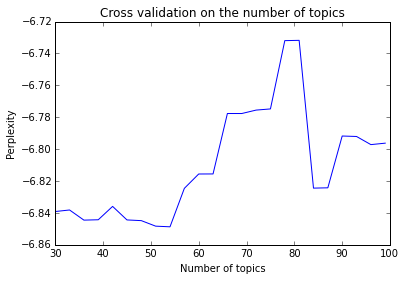

In [10]:
plt.plot([p[0] for p in perp_val], [p[1] for p in perp_val])
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')

plt.title('Cross validation on the number of topics')
plt.show()

In [15]:
np.save('temp/reviews_features/ovi_78_gamma', model_ovi.gamma)
np.save('temp/reviews_features/ovi_78_topics', model_ovi.topics)

### Gibbs sampling


In [34]:
%%time
iterations = 1500

model_gs = lda.LDA(n_topics=num_topics, n_iter=iterations, random_state=1)
model_gs.fit(dtm)

CPU times: user 1h 7min 23s, sys: 17.6 s, total: 1h 7min 41s
Wall time: 1h 8min 9s


In [40]:
%%time
# Computing the perplexity of the Gibbs sampling to compare it to the OVI one
gs_perp =  lda.LDA(n_topics=num_topics, n_iter=iterations, random_state=1)
# Fit the model on the trainset
gs_perp.fit(dtm_train)

CPU times: user 56min 12s, sys: 16.2 s, total: 56min 28s
Wall time: 57min 5s


In [42]:
%%time
# Infering the gamma on the test set
gamma_test = gs_perp.transform(dtm_test)

CPU times: user 2min 39s, sys: 3.51 s, total: 2min 42s
Wall time: 2min 49s


/usr/local/lib/python2.7/site-packages/lda/lda.py:197: RuntimeWarning: invalid value encountered in true_divide
  theta_doc /= sum(theta_doc)


In [48]:
# Computing the perplexity (log-likelihood of the test set corpus based on the lda model fitted on the train set)
topics = gs_perp.components_

num = 0
denom = 0
for i in range(gamma_test.shape[0]):
    doc_idx = np.nonzero(dtm_test[i, :])[0]
    doc_cts = dtm_test[i, doc_idx]
    num += np.sum(np.log(np.dot(gamma_test[i, :],
                  topics[:, doc_idx]))*doc_cts)
    denom += np.sum(doc_cts)
gs_perplexity = num/denom
print'Gibbs sampling perplexity is', gs_perplexity

Gibbs sampling perplexity is -6.40572218054


In [39]:
np.save('temp/reviews_features/lda_gs_54_gamma', model_gs.doc_topic_)
np.save('temp/reviews_features/lda_gs_54_topics', model_gs.components_)

### NMF


In [29]:
%%time

model_nmf = sklearn.decomposition.NMF(num_topics,max_iter=2000)
model_nmf.fit(dtm)

CPU times: user 7min 57s, sys: 1min 55s, total: 9min 52s
Wall time: 6min 41s


In [31]:
gamma_nmf = model_nmf.transform(dtm)

In [38]:
np.save('temp/reviews_features/nmf_54_gamma', gamma_nmf)
np.save('temp/reviews_features/nmf_54_topics', model_nmf.components_)